In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

The number of images in imagesTr: 123
The number of images in labelsTr: 123
Size of the first image in imagesTr: (180, 180, 125)
Size of the first image in labelsTr: (180, 180, 125)
Size of the other image in imagesTr: (200, 200, 209)
Size of the other image in labelsTr: (200, 200, 209)
There are images with different sizes. We need to normalize the data and bring them to the same size


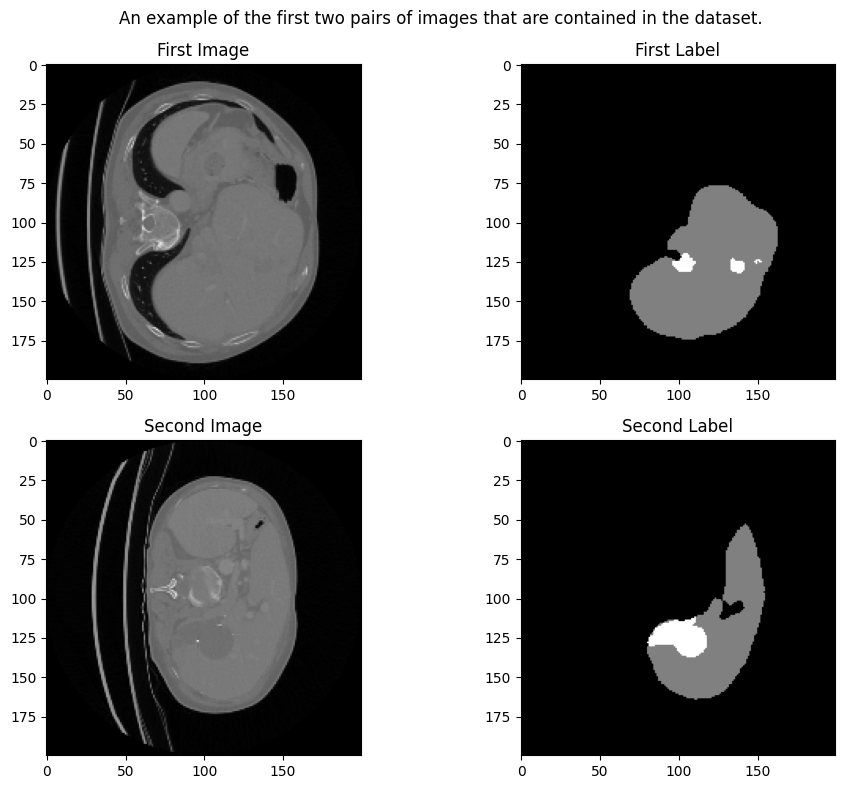

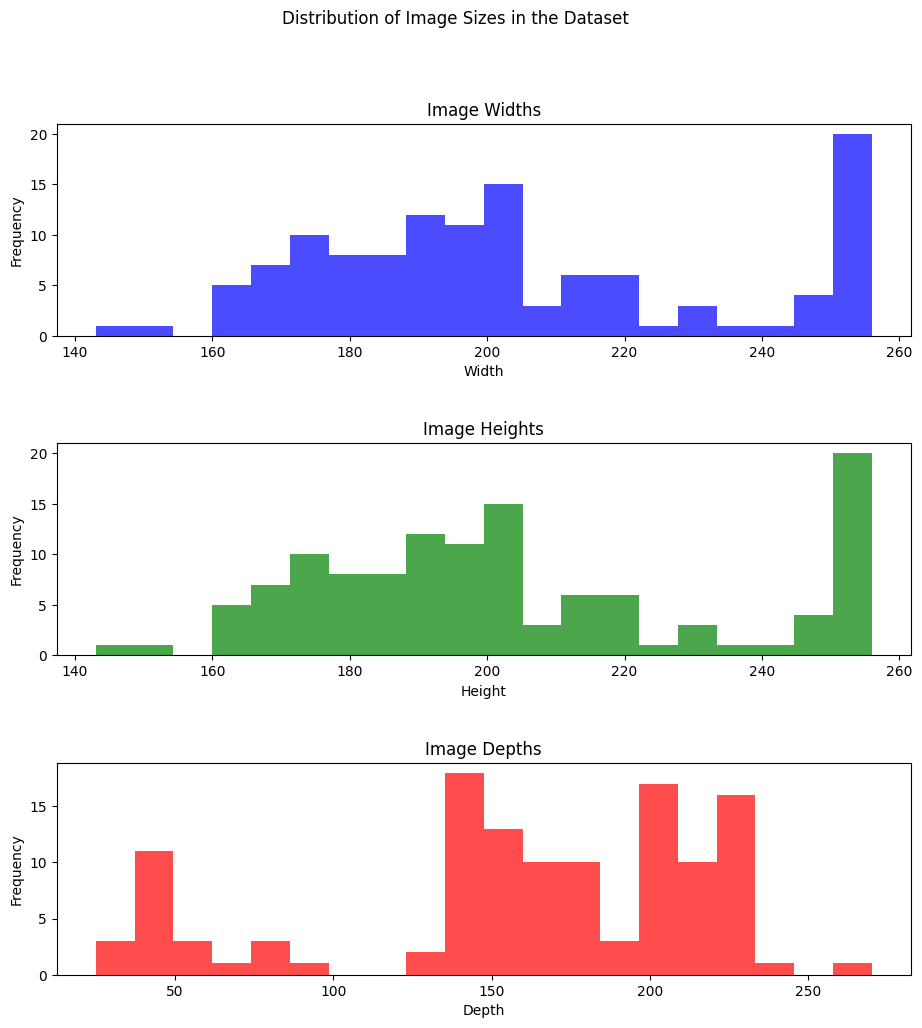

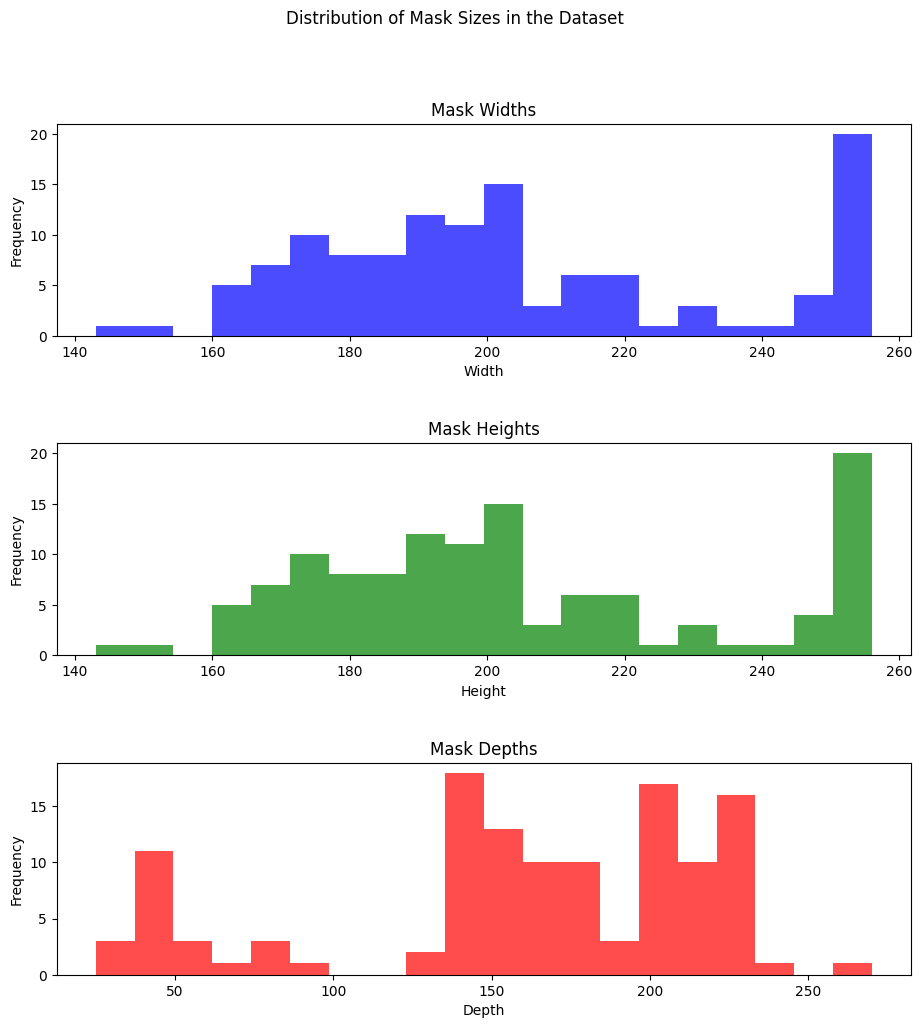

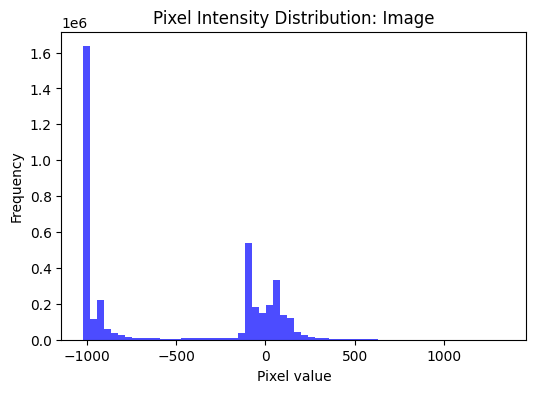

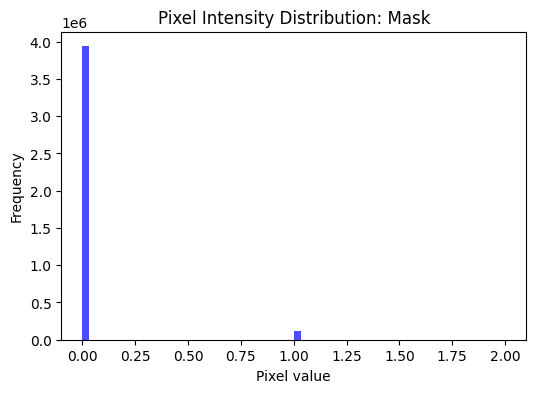

In [5]:
import os
import numpy as np
import nibabel as nib
from matplotlib import pyplot as plt
from glob import glob
import torch

root = "/kaggle/input/3d-liver-segmentation"

im_nii_paths = sorted(glob(f"{root}/Task03_Liver_rs/imagesTr/*.nii"))
gt_nii_paths = sorted(glob(f"{root}/Task03_Liver_rs/labelsTr/*.nii"))
# -----------------------------------------------------------------------------------------------------------------------    

num_images = len(im_nii_paths)
num_labels = len(gt_nii_paths)

print(f"The number of images in imagesTr: {num_images}")
print(f"The number of images in labelsTr: {num_labels}")

# -----------------------------------------------------------------------------------------------------------------------    
def read_nii(file_path):
    return nib.load(file_path).get_fdata()

first_im_shape = read_nii(im_nii_paths[0]).shape
first_gt_shape = read_nii(gt_nii_paths[0]).shape
print(f"Size of the first image in imagesTr: {first_im_shape}")
print(f"Size of the first image in labelsTr: {first_gt_shape}")

random_im_shape = read_nii(im_nii_paths[5]).shape
random_gt_shape = read_nii(gt_nii_paths[5]).shape
print(f"Size of the other image in imagesTr: {random_im_shape}")
print(f"Size of the other image in labelsTr: {random_gt_shape}")

all_same_size = True
for im_path, gt_path in zip(im_nii_paths, gt_nii_paths):
    im_shape = read_nii(im_path).shape
    gt_shape = read_nii(gt_path).shape
    if im_shape != first_im_shape or gt_shape != first_gt_shape:
        all_same_size = False
        break

if all_same_size:
    print("All images are the same size")
else:
    print("There are images with different sizes. We need to normalize the data and bring them to the same size")

# -----------------------------------------------------------------------------------------------------------------------    
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

image_1 = read_nii(im_nii_paths[15])
label_1 = read_nii(gt_nii_paths[15])

# Ищем срез с максимальным количеством ненулевых меток
max_label_slice_1 = np.argmax(np.sum(label_1, axis=(0, 1)))

# Визуализация первого изображения и метки
axes[0, 0].imshow(image_1[:, :, max_label_slice_1], cmap='gray')
axes[0, 0].set_title('First Image')
axes[0, 1].imshow(label_1[:, :, max_label_slice_1], cmap='gray')
axes[0, 1].set_title('First Label')

image_2 = read_nii(im_nii_paths[5])
label_2 = read_nii(gt_nii_paths[5])

max_label_slice_2 = np.argmax(np.sum(label_2, axis=(0, 1)))

# Визуализация второго изображения и метки
axes[1, 0].imshow(image_2[:, :, max_label_slice_2], cmap='gray')
axes[1, 0].set_title('Second Image')
axes[1, 1].imshow(label_2[:, :, max_label_slice_2], cmap='gray')
axes[1, 1].set_title('Second Label')

plt.suptitle('An example of the first two pairs of images that are contained in the dataset.')
plt.tight_layout()
plt.show()
# -----------------------------------------------------------------------------------------------------------------------        
    
# Собираем информацию о размерах изображений
image_sizes = []

for im_path in im_nii_paths:
    image = nib.load(im_path).get_fdata()
    image_sizes.append(image.shape)

image_widths, image_heights, image_depths = zip(*image_sizes)

# Визуализируем
plt.figure(figsize=(10, 10))  

plt.subplot(3, 1, 1)
plt.hist(image_widths, bins=20, color='blue', alpha=0.7)
plt.title('Image Widths')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.subplot(3, 1, 2)
plt.hist(image_heights, bins=20, color='green', alpha=0.7)
plt.title('Image Heights')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.subplot(3, 1, 3)
plt.hist(image_depths, bins=20, color='red', alpha=0.7)
plt.title('Image Depths')
plt.xlabel('Depth')
plt.ylabel('Frequency')

plt.tight_layout(pad=3.0)  
plt.suptitle('Distribution of Image Sizes in the Dataset', y=1.05)  

plt.show()

# -----------------------------------------------------------------------------------------------------------------------  
gt_sizes = []

for gt_path in gt_nii_paths:
    gt = nib.load(gt_path).get_fdata()
    gt_sizes.append(gt.shape)

gt_widths, gt_heights, gt_depths = zip(*gt_sizes)

# Визуализация 
plt.figure(figsize=(10, 10))  

plt.subplot(3, 1, 1)
plt.hist(gt_widths, bins=20, color='blue', alpha=0.7)
plt.title('Mask Widths')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.subplot(3, 1, 2)
plt.hist(gt_heights, bins=20, color='green', alpha=0.7)
plt.title('Mask Heights')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.subplot(3, 1, 3)
plt.hist(gt_depths, bins=20, color='red', alpha=0.7)
plt.title('Mask Depths')
plt.xlabel('Depth')
plt.ylabel('Frequency')

plt.tight_layout(pad=3.0)  
plt.suptitle('Distribution of Mask Sizes in the Dataset', y=1.05)  

plt.show()
# -----------------------------------------------------------------------------------------------------------------------  

# функция для вывода распределения интенсивности пикселей
def plot_intensity_distribution(image_data, title):
    plt.figure(figsize=(6, 4))
    plt.hist(image_data.flatten(), bins=60, color='blue', alpha=0.7)
    plt.title(f'Pixel Intensity Distribution: {title}')
    plt.xlabel('Pixel value')
    plt.ylabel('Frequency')
    plt.show()

# Визуализация распределений для первого изображения и маски
plot_intensity_distribution(read_nii(im_nii_paths[0]), "Image")
plot_intensity_distribution(read_nii(gt_nii_paths[0]), "Mask")